In [1]:
import warnings

warnings.filterwarnings("ignore")
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to tune model, get different metric scores, and split data.
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#libraries to help with model building
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
    BaggingRegressor)
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

## Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip3 install pickle5
import pickle5 as pickle

     |████████████████████████████████| 133kB 33.2MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219278 sha256=8f78eb5c6590a91b1bdada16938f7bd6d95c7367a4342d9a46ad3338aa2e7a17
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [4]:
!pip install --upgrade pandas

     |████████████████████████████████| 10.8MB 24.5MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.3.0 which is incompatible.
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


In [3]:
import pickle5 as pickle
with open('/content/gdrive/MyDrive/test.pkl', "rb") as fh:
  test_final = pickle.load(fh)

In [4]:
import pickle5 as pickle
with open('/content/gdrive/MyDrive/train.pkl', "rb") as f:
  train = pickle.load(f)

In [5]:
train.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_category,sub_category,item_category,log_price,name_len,item_len,compound,negative,positive,neutral,text
0,0,mlb cincinnati reds t shirt size xl,3,missing,10.0,1,no description yet,Men,Tops,T-shirts,2.397895,7,3,-0.2960,0.524,0.000,0.476,mlb cincinnati reds t shirt size xl no descrip...
1,1,razer blackwidow chroma keyboard,3,razer,52.0,0,this keyboard great condition works like came ...,Electronics,Computers & Tablets,Components & Parts,3.970292,4,21,0.8957,0.000,0.375,0.625,razer blackwidow chroma keyboard this keyboard...
2,2,ava viv blouse,1,target,10.0,1,adorable top hint lace key hole back the pale ...,Women,Tops & Blouses,Blouse,2.397895,3,16,0.6124,0.000,0.278,0.722,ava viv blouse adorable top hint lace key hole...
3,3,leather horse statues,1,missing,35.0,1,new tags leather horses retail rm stand foot h...,Home,Home Décor,Home Décor Accents,3.583519,3,21,0.6808,0.000,0.228,0.772,leather horse statues new tags leather horses ...
4,4,24k gold plated rose,1,complete,44.0,0,complete certificate authenticity,Women,Jewelry,Necklaces,3.806662,4,3,0.0000,0.000,0.000,1.000,24k gold plated rose complete certificate auth...


In [6]:
test_final.head()

,test_id,name,item_condition_id,brand_name,shipping,item_description,main_categoey,sub_category,item_category,name_len,item_len,compound,negative,positive,neutral,text
0,0,breast cancer i fight like a girl ring,1,ring,1,size 7,Women,Jewelry,Rings,8,2,0.0000,0.000,0.000,1.000,breast cancer i fight like a girl ring size 7
1,1,25 pcs new 7 5 x12 kraft bubble mailers,1,kraft,1,25 pcs new 7 5 x12 kraft bubble mailers lined ...,Other,Office supplies,Shipping Supplies,9,34,0.8750,0.000,0.282,0.718,25 pcs new 7 5 x12 kraft bubble mailers 25 pcs...
2,2,coach bag,1,coach,1,brand new coach bag bought rm coach outlet,Vintage & Collectibles,Bags and Purses,Handbag,2,8,0.0000,0.000,0.000,1.000,coach bag brand new coach bag bought rm coach ...
3,3,floral kimono,2,worn,0,floral kimono never worn lightweight perfect h...,Women,Sweaters,Cardigan,2,8,-0.2755,0.275,0.173,0.551,floral kimono floral kimono never worn lightwe...
4,4,life after death,3,missing,1,rediscovering life loss loved one tony cooke p...,Other,Books,Religion & Spirituality,3,21,0.1531,0.281,0.299,0.419,life after death rediscovering life loss loved...


In [7]:
print(train.shape)

(1462949, 18)


In [8]:
train.isnull().sum()

train_id             0
name                 0
item_condition_id    0
brand_name           0
price                0
shipping             0
item_description     0
main_category        0
sub_category         0
item_category        0
log_price            0
name_len             0
item_len             0
compound             0
negative             0
positive             0
neutral              0
text                 0
dtype: int64

In [9]:
print('Number of data_point is-{} and Number of features/variables is-{}'.format(train.shape[0],train.shape[1]))

Number of data_point is-1462949 and Number of features/variables is-18


In [10]:
train.columns

Index(['train_id', 'name', 'item_condition_id', 'brand_name', 'price',
       'shipping', 'item_description', 'main_category', 'sub_category',
       'item_category', 'log_price', 'name_len', 'item_len', 'compound',
       'negative', 'positive', 'neutral', 'text'],
      dtype='object')

In [11]:
df_train,df_test=train_test_split(train,test_size=0.25)

In [12]:
from scipy.sparse import csr_matrix
def dummy_encoding(data):
    data_transform = csr_matrix(pd.get_dummies(data[["item_condition_id","shipping"]], sparse = True).values)
    return data_transform

In [13]:
df_train["shipping"] = df_train["shipping"].astype("category")
df_test["shipping"] = df_test["shipping"].astype("category")
test_final["shipping"] = test_final["shipping"].astype("category")

df_train["item_condition_id"] = df_train["item_condition_id"].astype("category")
df_test["item_condition_id"] = df_test["item_condition_id"].astype("category")
test_final["item_condition_id"] = test_final["item_condition_id"].astype("category")
train_dummies=dummy_encoding(df_train)
test_dummies=dummy_encoding(df_test)
test_final_dummies=dummy_encoding(test_final)
print(train_dummies.shape)
print(test_dummies.shape)
print(test_final_dummies.shape)

(1097211, 7)
(365738, 7)
(3460725, 7)


## TextEncoding

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
def text_encoding(train,test,test_final,type_val,params):
    if type_val == 'BOW':
        vectorizer = CountVectorizer(ngram_range = params[0],min_df=1,max_df=25,max_features=params[1])  
    else :
        vectorizer=TfidfVectorizer(ngram_range = params[0],min_df=1,max_df=25,max_features=params[1])
    train_transform = vectorizer.fit_transform(train)
    test_final_transform=vectorizer.transform(test_final)
    test_transform = vectorizer.transform(test)
    return train_transform,test_transform,test_final_transform

In [65]:
%%time
train_bow_name,test_bow_name,test_final_bow_name = text_encoding(df_train['name'],df_test['name'],test_final['name'],'TFIDF',((1,4),50000))
print(train_bow_name.shape,test_bow_name.shape,test_final_bow_name.shape)

(1097211, 50000) (365738, 50000) (3460725, 50000)
CPU times: user 1min 16s, sys: 765 ms, total: 1min 16s
Wall time: 1min 17s


In [66]:
%%time
train_tfidf_desc,test_tfidf_desc,test_final_tfidf_desc = text_encoding(df_train['item_description'],df_test['item_description'],test_final['item_description'],'TFIDF',((1,3),100000))
print(train_tfidf_desc.shape,test_tfidf_desc.shape,test_final_tfidf_desc.shape)

(1097211, 100000) (365738, 100000) (3460725, 100000)
CPU times: user 4min 30s, sys: 4.22 s, total: 4min 34s
Wall time: 4min 34s


## Label Binarizer

In [14]:
from sklearn.preprocessing import LabelBinarizer
def label_binarizer(train,test,test_final):
    lb_brand_name = LabelBinarizer(sparse_output=True)
    lb_brand_name.fit(train)
    train_label=lb_brand_name.transform(train)
    test_label=lb_brand_name.transform(test)
    test_final_label=lb_brand_name.transform(test_final)
    return train_label,test_label,test_final_label

In [15]:
%%time
train_brand,test_brand,test_final_brand=label_binarizer(df_train['brand_name'],df_test['brand_name'],test_final['brand_name'])
print(train_brand.shape,test_brand.shape,test_final_brand.shape)

(1097211, 4549) (365738, 4549) (3460725, 4549)
CPU times: user 9min 28s, sys: 1.64 s, total: 9min 29s
Wall time: 9min 30s


In [16]:
%%time
train_main,test_main,test_final_main=label_binarizer(df_train['main_category'],df_test['main_category'],test_final['main_categoey'])
print(train_main.shape,test_main.shape,test_final_main.shape)

(1097211, 11) (365738, 11) (3460725, 11)
CPU times: user 22.7 s, sys: 71.1 ms, total: 22.8 s
Wall time: 22.7 s


In [17]:
%%time
train_sub,test_sub,test_final_sub=label_binarizer(df_train['sub_category'],df_test['sub_category'],test_final['sub_category'])
print(train_sub.shape,test_sub.shape,test_final_sub.shape)

(1097211, 114) (365738, 114) (3460725, 114)
CPU times: user 42.3 s, sys: 152 ms, total: 42.4 s
Wall time: 43 s


In [18]:
%%time
train_item,test_item,test_final_item=label_binarizer(df_train['item_category'],df_test['item_category'],test_final['item_category'])
print(train_item.shape,test_item.shape,test_final_item.shape)

(1097211, 857) (365738, 857) (3460725, 857)
CPU times: user 2min 41s, sys: 460 ms, total: 2min 42s
Wall time: 2min 42s


## Normalizer

In [19]:
from sklearn.preprocessing import Normalizer
def data_Normalizer(train,test,test_final):
    norm=Normalizer()
    norm.fit(train)
    train_norm=norm.transform(train)
    test_norm=norm.transform(test)
    test_final_norm=norm.transform(test_final)
    return train_norm,test_norm,test_final_norm

In [20]:
train_name_len,test_name_len,test_final_name_len=data_Normalizer(df_train['name_len'].values.reshape(-1,1),df_test['name_len'].values.reshape(-1,1),test_final['name_len'].values.reshape(-1,1))

In [21]:
train_item_len,test_item_len,test_final_item_len=data_Normalizer(df_train['item_len'].values.reshape(-1,1),df_test['item_len'].values.reshape(-1,1),test_final['item_len'].values.reshape(-1,1))

In [22]:
train_pos=df_train['positive'].values.reshape(-1,1)
test_pos=df_test['positive'].values.reshape(-1,1)
test_final_pos=test_final['positive'].values.reshape(-1,1)

In [23]:
train_neg=df_train['negative'].values.reshape(-1,1)
test_neg=df_test['negative'].values.reshape(-1,1)
test_final_neg=test_final['negative'].values.reshape(-1,1)

In [24]:
train_neu=df_train['neutral'].values.reshape(-1,1)
test_neu=df_test['neutral'].values.reshape(-1,1)
test_final_neu=test_final['neutral'].values.reshape(-1,1)

In [25]:
train_com=df_train['compound'].values.reshape(-1,1)
test_com=df_test['compound'].values.reshape(-1,1)
test_final_com=test_final['compound'].values.reshape(-1,1)

In [67]:
%%time
from scipy.sparse import hstack
train_s=hstack((train_dummies,train_bow_name,train_tfidf_desc,train_brand,train_main,train_sub,train_item,train_name_len,train_item_len,train_pos,train_neg,train_neu,train_com)).tocsr().astype('float32')
test_s=hstack((test_dummies,test_bow_name,test_tfidf_desc,test_brand,test_main,test_sub,test_item,test_name_len,test_item_len,test_pos,test_neg,test_neu,test_com)).tocsr().astype('float32')
test_final_s=hstack((test_final_dummies,test_final_bow_name,test_final_tfidf_desc,test_final_brand,test_final_main,test_final_sub,test_final_item,test_final_name_len,test_final_item_len,test_final_pos,test_final_neg,test_final_neu,test_final_com)).tocsr().astype('float32')

CPU times: user 3.85 s, sys: 299 ms, total: 4.15 s
Wall time: 4.13 s


In [68]:
Y_train=df_train['log_price']
Y_test=df_test['log_price']

In [69]:
print("Final Train Shape",train_s.shape,Y_train.shape)
print("Final Test Shape",test_s.shape,Y_test.shape)
print("Test shape",test_final_s.shape)

Final Train Shape (1097211, 155544) (1097211,)
Final Test Shape (365738, 155544) (365738,)
Test shape (3460725, 155544)


In [36]:
from sklearn.metrics import mean_squared_error, make_scorer,mean_squared_log_error
def rmsle(y_pred, y):
    if len(y_pred)==len(y):
        return np.sqrt(mean_squared_log_error(np.expm1(y_pred), np.expm1(y)))

In [37]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import make_scorer
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [70]:
%%time
models = []  # Empty list to store all the models
# Appending pipelines for each model into the list


models.append((
    "Ridge",
              Pipeline(
            steps=[
                ("Ridge", Ridge(solver = "lsqr", fit_intercept=False)),
            ]
        ),
)
)
models.append((
    "LGBM Regressor",
              Pipeline(
            steps=[
                ("LGBM ", LGBMRegressor()),
            ]
        ),
)
)


models.append((
           "SGD Regressor",
              Pipeline(
            steps=[
                ("SGD ", SGDRegressor()),
            ]
        ),
)
)



results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models

# loop through all models to get the mean cross validated score
from tqdm import tqdm
for name, model in tqdm(models):
    # Setting number of splits equal to 5
    scores = cross_val_score(model,train_s,Y_train, cv=5,
                             scoring=make_scorer(rmsle, greater_is_better=False))
    results.append(-1*scores)
    names.append(name)
    print("{}: {}".format(name, -1*scores.mean() * 100))

 33%|███▎      | 1/3 [00:27<00:54, 27.45s/it]

Ridge: 54.030055341222564


 67%|██████▋   | 2/3 [03:22<01:11, 71.85s/it]

LGBM Regressor: 56.56499730269095


100%|██████████| 3/3 [03:41<00:00, 73.86s/it]

SGD Regressor: 56.93410492451233
CPU times: user 6min 27s, sys: 1.83 s, total: 6min 28s
Wall time: 3min 41s


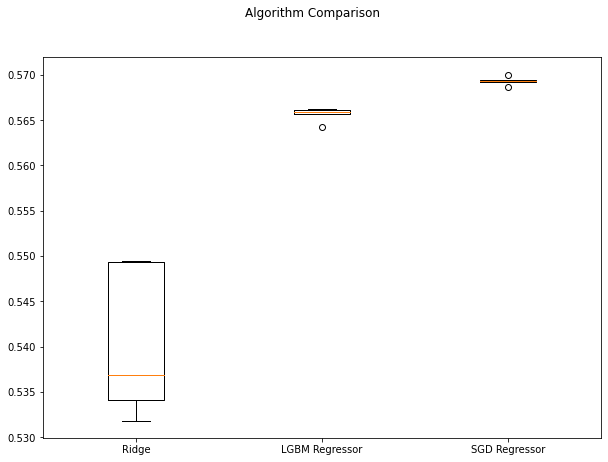

In [71]:
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## GridSearchCV(LGBM)

In [84]:
%%time
params={'n_estimators':[100,500,1000],'learning_rate':[0.05,0.15,0.25]}
model_lgbm= LGBMRegressor(colsample_bytree=0.8,
               min_child_samples=50)

model=GridSearchCV(estimator = model_lgbm, param_grid = params,
                                    return_train_score=True, scoring = 'neg_mean_squared_error',\
                                    cv = 3,verbose=2)
model.fit(train_s,Y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] learning_rate=0.05, n_estimators=100 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............. learning_rate=0.05, n_estimators=100, total=  19.6s
[CV] learning_rate=0.05, n_estimators=100 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.4s remaining:    0.0s


[CV] ............. learning_rate=0.05, n_estimators=100, total=  17.9s
[CV] learning_rate=0.05, n_estimators=100 ............................
[CV] ............. learning_rate=0.05, n_estimators=100, total=  18.6s
[CV] learning_rate=0.05, n_estimators=500 ............................
[CV] ............. learning_rate=0.05, n_estimators=500, total= 1.6min
[CV] learning_rate=0.05, n_estimators=500 ............................
[CV] ............. learning_rate=0.05, n_estimators=500, total= 1.6min
[CV] learning_rate=0.05, n_estimators=500 ............................
[CV] ............. learning_rate=0.05, n_estimators=500, total= 1.6min
[CV] learning_rate=0.05, n_estimators=1000 ...........................
[CV] ............ learning_rate=0.05, n_estimators=1000, total= 2.8min
[CV] learning_rate=0.05, n_estimators=1000 ...........................
[CV] ............ learning_rate=0.05, n_estimators=1000, total= 2.8min
[CV] learning_rate=0.05, n_estimators=1000 ...........................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 75.0min finished


CPU times: user 2h 30min 20s, sys: 8.38 s, total: 2h 30min 29s
Wall time: 1h 16min 23s


In [85]:
model.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.25, max_depth=-1,
              min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [86]:
lgbm_model = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.25, max_depth=-1,
              min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


lgbm_model.fit(train_s, Y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.25, max_depth=-1,
              min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [87]:
print('Train RMSLE = ',np.sqrt(mean_squared_error(Y_train,lgbm_model.predict(train_s))))
print('Test RMSLE = ',np.sqrt(mean_squared_error(Y_test,lgbm_model.predict(test_s))))

Train RMSLE =  0.5186514543110425
Test RMSLE =  0.5300267626827093


## GridSearchCV(SGDRegressor)

In [47]:
parameters = {'alpha':[10**x for x in range(-10, 10)],
              }
model_lr_reg = SGDRegressor(loss = "squared_loss",fit_intercept=False,l1_ratio=0.6)
model=GridSearchCV(estimator = model_lr_reg, param_grid = parameters,
                                    return_train_score=True, scoring = 'neg_mean_squared_error',\
                                    cv = 5,verbose=2)
model.fit(train_s,Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] alpha=1e-10 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... alpha=1e-10, total=   3.3s
[CV] alpha=1e-10 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] ...................................... alpha=1e-10, total=   2.9s
[CV] alpha=1e-10 .....................................................
[CV] ...................................... alpha=1e-10, total=   2.8s
[CV] alpha=1e-10 .....................................................
[CV] ...................................... alpha=1e-10, total=   2.9s
[CV] alpha=1e-10 .....................................................
[CV] ...................................... alpha=1e-10, total=   2.8s
[CV] alpha=1e-09 .....................................................
[CV] ...................................... alpha=1e-09, total=   2.8s
[CV] alpha=1e-09 .....................................................
[CV] ...................................... alpha=1e-09, total=   2.8s
[CV] alpha=1e-09 .....................................................
[CV] ...................................... alpha=1e-09, total=   2.8s
[CV] alpha=1e-09 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 17.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=False,
                                    l1_ratio=0.6, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                   0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000, 1000000, 10000000, 100000000,
   

In [49]:
model.best_estimator_

SGDRegressor(alpha=1e-10, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=False, l1_ratio=0.6,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [74]:
from sklearn.linear_model import RidgeCV
sgd_model = SGDRegressor(alpha=1e-10, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=False, l1_ratio=0.6,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
sgd_model.fit(train_s, Y_train)

SGDRegressor(alpha=1e-10, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=False, l1_ratio=0.6,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [75]:
print('Train RMSLE = ',np.sqrt(mean_squared_error(Y_train,sgd_model.predict(train_s))))
print('Test RMSLE = ',np.sqrt(mean_squared_error(Y_test,sgd_model.predict(test_s))))

Train RMSLE =  0.5639109057158059
Test RMSLE =  0.5660080278922949


## GridSearchCV(Ridge )

In [53]:
%%time
parameters = {'alpha':[0.0001,0.001,0.01,0.1,1.0,2.0,4.0,5.0,6.0]}
model_ridge = Ridge(
    solver='auto', fit_intercept=True,
    max_iter=100, normalize=False, tol=0.05, random_state = 1,
)
model=GridSearchCV(estimator = model_ridge, param_grid = parameters,
                                    return_train_score=True, scoring = 'neg_mean_squared_error',
                                    cv = 5,
                                    verbose=2)
model.fit(train_s,Y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] alpha=0.0001 ....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................................... alpha=0.0001, total=   2.7s
[CV] alpha=0.0001 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] ..................................... alpha=0.0001, total=   1.3s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   1.3s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   1.3s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   1.4s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   1.6s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   2.3s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   1.3s
[CV] alpha=0.001 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.1min finished


CPU times: user 1min 10s, sys: 46 s, total: 1min 56s
Wall time: 1min 5s


In [54]:
model.best_estimator_

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=100,
      normalize=False, random_state=1, solver='auto', tol=0.05)

In [76]:
ridge_model = Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=100,
      normalize=False, random_state=1, solver='auto', tol=0.05)
ridge_model.fit(train_s, Y_train)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=100,
      normalize=False, random_state=1, solver='auto', tol=0.05)

In [77]:
print('Train RMSLE = ',np.sqrt(mean_squared_error(Y_train,ridge_model.predict(train_s))))
print('Test RMSLE = ',np.sqrt(mean_squared_error(Y_test,ridge_model.predict(test_s))))

Train RMSLE =  0.5704125583955401
Test RMSLE =  0.5721537838627493


## RidgeCV

In [78]:
from sklearn.linear_model import RidgeCV
ridgecv_model = RidgeCV(
    fit_intercept=True, alphas=[6.0],
    normalize=False, cv = 2, scoring='neg_mean_squared_error',
)
ridgecv_model.fit(train_s, Y_train)

RidgeCV(alphas=array([6.]), cv=2, fit_intercept=True, gcv_mode=None,
        normalize=False, scoring='neg_mean_squared_error',
        store_cv_values=False)

In [79]:
print('Train RMSLE = ',np.sqrt(mean_squared_error(Y_train,ridgecv_model.predict(train_s))))
print('Test RMSLE = ',np.sqrt(mean_squared_error(Y_test,ridgecv_model.predict(test_s))))

Train RMSLE =  0.4862664117503523
Test RMSLE =  0.5173075316849575


## Ensemble

In [80]:
ridgecv_predict = np.expm1(ridgecv_model.predict(test_final_s))
lgbm_predict = np.expm1(lgbm_model.predict(test_final_s))

In [89]:
y_test_pred_ridgecv=ridgecv_model.predict(train_s)
y_test_pred_lgbm=lgbm_model.predict(train_s)

In [94]:
weights = list(np.linspace(0.1,1,25))
scores = []

In [95]:
from tqdm import tqdm
for w in tqdm(weights):
    pred= (w*y_test_pred_ridgecv) + (1-w)*(y_test_pred_lgbm)
    scores.append(rmsle(Y_train,pred))

100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


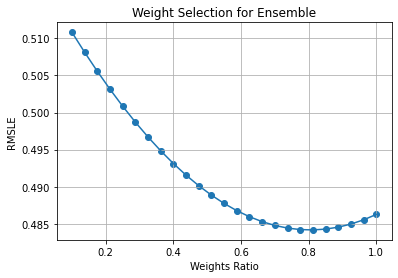

In [96]:
import matplotlib.pyplot as plt
plt.plot(weights, scores)
plt.scatter(weights, scores)
plt.xlabel("Weights Ratio")
plt.ylabel("RMSLE")
plt.title("Weight Selection for Ensemble")
plt.grid()
plt.show()

In [97]:
df = pd.DataFrame({'weights' : weights,'scores':scores})
df.head(5)

,weights,scores
0,0.1000,0.510827
1,0.1375,0.508132
2,0.1750,0.505572
3,0.2125,0.503148
4,0.2500,0.500861


In [98]:
w = df.weights[df.scores == min(df.scores)].values[0]
print(w)

0.8125


In [99]:
final_pred= ((w*ridgecv_predict) + ((1-w)*lgbm_predict))

In [100]:
test_id=test_final['test_id']

In [101]:
final_submission=pd.DataFrame({'test_id':test_id,'price':final_pred})

In [102]:
final_submission.to_csv('submission_ensemble_2.csv',index=False)